In [1]:
import cv2
import io
from IPython.display import display, Image as IPImage
import numpy as np
import random
import cv2
import os

In [2]:
logo_path='images/logos/logo_guilbaut.png'
file_path='images/invoice_3.png'

logo = cv2.imread(logo_path, 0)  # path to the logo image
scanned_image = cv2.imread(file_path, 0)  # path to a scanned image

In [3]:
def view(img):
    is_success, buffer = cv2.imencode(".png", img)
    io_buf = io.BytesIO(buffer)
    display(IPImage(data=io_buf.getvalue(), format='png'))

In [4]:
def find_logo(template, target):
    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
    keypoints_target, descriptors_target = sift.detectAndCompute(target, None)

    # Feature matching
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors_template, descriptors_target, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good_matches.append(m)

    # Draw matches - for visualization
    matched_image = cv2.drawMatches(template, keypoints_template, target, keypoints_target, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Return the matched image for visualization
    return matched_image


In [5]:
def draw_rectangles(image, rectangles):
    for rec in rectangles:
        x, y, w, h = rec
        random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(image, (x, y), (x + w, y + h), random_color, 2)

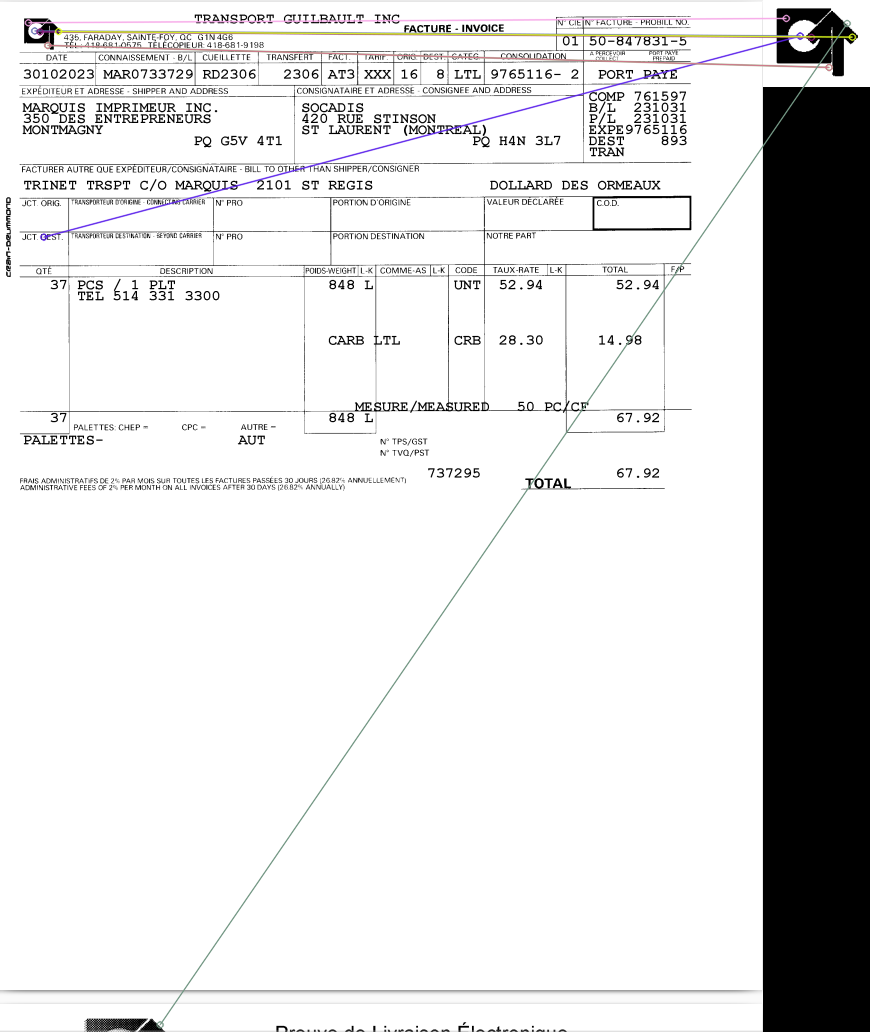

In [6]:
image = cv2.imread(file_path)
logo = cv2.imread(logo_path)

l = find_logo(image, logo)
# draw_rectangles(image, l)
view(l)

## ORBR

In [7]:
import cv2
import numpy as np

# Load the logo image and the scanned image

# Initialize the ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(logo, None)
kp2, des2 = orb.detectAndCompute(scanned_image, None)

# Create BFMatcher object with cross-check
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Match descriptors
matches = bf.match(des1, des2)


# Sort them in the order of their distance (the lower the better)
matches = sorted(matches, key=lambda x: x.distance)

# Define a threshold for the number of matches we want to find
MIN_MATCH_COUNT = 2

# If enough matches are found, we proceed with homography
if len(matches) > MIN_MATCH_COUNT:
    # Extract location of points in both images
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Find the homography matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # The mask can be used to draw only inliers for matches
    matchesMask = mask.ravel().tolist()

    # Draw first 10 matches (you can increase this number as you like)
    img3 = cv2.drawMatches(logo, kp1, scanned_image, kp2, matches[:10], None, matchColor=(0, 255, 0), flags=2)

    # Show the matches
    cv2.imshow('Matches', img3)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Not enough matches are found - {}/{}".format(len(matches), MIN_MATCH_COUNT))
    matchesMask = None

# The homography matrix M transforms points from the logo image to the scanned image
# You can use M to project the logo's boundaries onto the scanned image, or to transform the entire logo image
# and overlay it on the scanned image for visual confirmation


## SIFT

In [8]:
import cv2
import numpy as np

def match_images(image, template, distance, match_count):
    # Check if SIFT is available in your OpenCV installation
    if not hasattr(cv2, 'SIFT'):
        print("Your OpenCV version does not have SIFT enabled.")
        return None

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT for both images
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(image, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher()

    # Match descriptors with kNN algorithm to get the 2 nearest matches for each keypoint
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to find the good matches
    good_matches = []
    for m, n in matches:
        if m.distance < distance * n.distance:
            good_matches.append(m)

    # If enough good matches are found, we proceed with homography
    if len(good_matches) > match_count:
        # Extract location of good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find the homography matrix
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Use the mask to draw only inliers for good matches
        matchesMask = mask.ravel().tolist()

        # Draw good matches
        draw_params = dict(matchColor=(0, 255, 0),
                           singlePointColor=None,
                           matchesMask=matchesMask,
                           flags=2)

        img3 = cv2.drawMatches(template, kp1, image, kp2, good_matches, None, **draw_params)
        return M, img3
    else:
        print("Not enough good matches are found - {}/{}".format(len(good_matches), match_count))
        return None


In [9]:
_, img = match_images(image, logo, 0.75, 3)

cv2.imshow('Good Matches & Object detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()